## 0.1 Build dataset of song syllables with their spectrograms


### This notebook does the following:
 - Segments songs into individual syllables
 - Creates spectrograms for each syllables
 - Saves a dataset to be used in furhter analyses
 

In [1]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import seaborn as sns
import src

from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

from src.greti.read.paths import DATA_DIR
from src.avgn.utils.paths import most_recent_subdirectory, ensure_dir
from src.avgn.utils.hparams import HParams
from src.avgn.dataset import DataSet
from src.avgn.signalprocessing.create_spectrogram_dataset import *

from src.avgn.visualization.spectrogram import draw_spec_set
from src.avgn.visualization.projections import (
    scatter_spec,
    scatter_projections,
    draw_projection_transitions,
)
from src.avgn.visualization.quickplots import draw_projection_plots
import umap


### Select dataset and parameters
> Use output of the previous notebook (*_segmented)

In [3]:
DATASET_ID = "GRETI_HQ_2020_segmented"

n_jobs = -2
verbosity = 10

hparams = HParams(
    num_mel_bins=64,
    n_fft=1024,
    win_length_ms=15,
    hop_length_ms=3,
    mel_lower_edge_hertz=1200,
    mel_upper_edge_hertz=10000,
    butter_lowcut=1200,
    butter_highcut=10000,
    ref_level_db=30,
    min_level_db=-19,
    mask_spec=True,
    n_jobs=-2,
    verbosity=1,
    nex=-1,
)

In [4]:

# create a dataset object
dataset = DataSet(DATASET_ID, hparams=hparams)
dataset.sample_json
len(dataset.data_files)


loading json: 100%|██████████| 747/747 [00:02<00:00, 262.66it/s]
[Parallel(n_jobs=-2)]: Done 747 out of 747 | elapsed:    3.0s finished
getting unique individuals:   0%|          | 0/747 [00:00<?, ?it/s]

747

In [5]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain=[],
            key=key,
        )
        for key in tqdm(dataset.data_files.keys())
    )

syllable_df = pd.concat(syllable_dfs)
len(syllable_df)
syllable_df[:3]

0%|          | 0/747 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0169s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0570s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.1s
  9%|▉         | 70/747 [00:00<00:01, 499.73it/s][Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1219s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
 21%|██        | 154/747 [00:00<00:01, 522.46it/s][Parallel(n_jobs=-2)]: Batch computation too fast (0.1502s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.4s
100%|██████████| 747/747 [00:00<00:00, 751.69it/s]
[Parallel(n_jobs=-2)]: Done 628 

,start_time,end_time,indv,indvi,key
0,0.096,0.249,W71,0,W71-GRETI_HQ-20200419_070000-4.wav
1,0.294,0.360,W71,0,W71-GRETI_HQ-20200419_070000-4.wav
2,0.558,0.723,W71,0,W71-GRETI_HQ-20200419_070000-4.wav


### Get audio for dataset

In [6]:

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key],
            dataset.data_files[key].data["wav_loc"],
            dataset.hparams,
        )
        for key in tqdm(syllable_df.key.unique(), position=0, leave=True)
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

100%|██████████| 747/747 [00:53<00:00, 13.93it/s]
[Parallel(n_jobs=-2)]: Done 747 out of 747 | elapsed:   54.8s finished


6523

### Normalise audio

In [7]:

df_mask = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])
syllable_df = syllable_df[np.array(df_mask)]
sylls = syllable_df.audio.values

syllable_df["audio"] = [librosa.util.normalize(i) for i in syllable_df.audio.values]
sylls = syllable_df["audio"].values


100%|██████████| 6523/6523 [00:00<00:00, 1443160.93it/s]


- Plot amplitude envelope of a few syllables

96%|█████████▌| 24/25 [00:00<00:00, 963.31it/s]


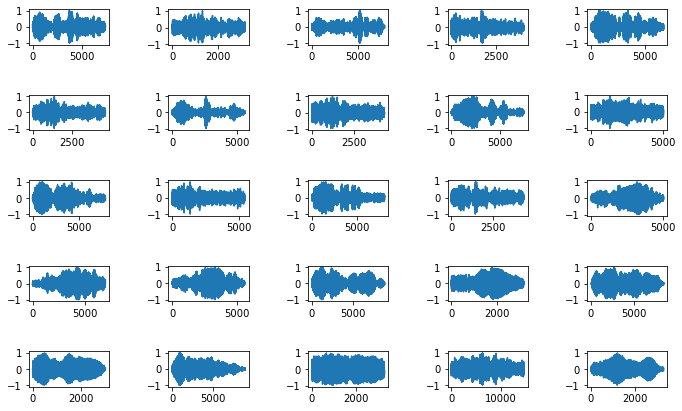

In [8]:
nrows = 5
ncols = 5
zoom = 2
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * zoom, nrows + zoom / 1.5)
)
for i, syll in tqdm(enumerate(sylls), total=nrows * ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows * ncols - 1:
        break

fig.tight_layout(pad=3.0)

### Create spectrograms

In [8]:

syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values


with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            position=0, 
            leave=True
        )
    )


getting syllable spectrograms:   0%|          | 0/6523 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0424s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0291s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.1s
getting syllable spectrograms:   2%|▏         | 154/6523 [00:00<00:04, 1441.63it/s][Parallel(n_jobs=-2)]: Batch computation too fast (0.0384s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0803s.) Sett

- Plot one example

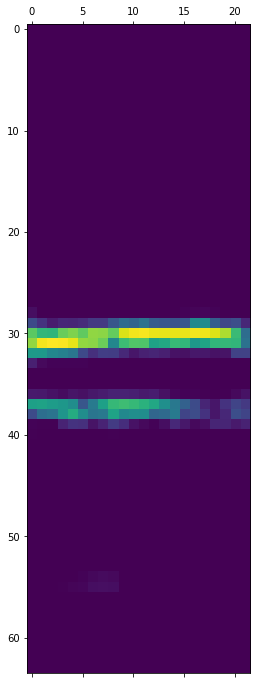

In [9]:
plt.matshow(syllables_spec[20])

### Rescale and pad spectrograms
> Rescaling removes duration differences, which you might not want 

In [10]:

# log_scaling_factor = 10

# with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
#     syllables_spec = parallel(
#         delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
#         for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
#     )


scaling spectrograms:   0%|          | 0/6523 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0051s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0102s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0152s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0203s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0283s.) Setting batch_size=32.
[Parallel(n_jobs=-2)]: Done 242 tasks      | elapsed:    0.1s
scaling spe

In [9]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)


with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(syllables_spec, desc="padding spectrograms", leave=False)
    )

padding spectrograms:   0%|          | 0/6523 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0074s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0212s.) Setting batch_size=4.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0162s.) Setting batch_size=8.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0280s.) Setting batch_size=16.
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.0424s.) Setting batch_size=32.
padding spectrograms:   7%|▋         | 434/6523 [00:00<00:01, 3619.36it/s

- Plot a few

105it [00:00, 24515.80it/s]


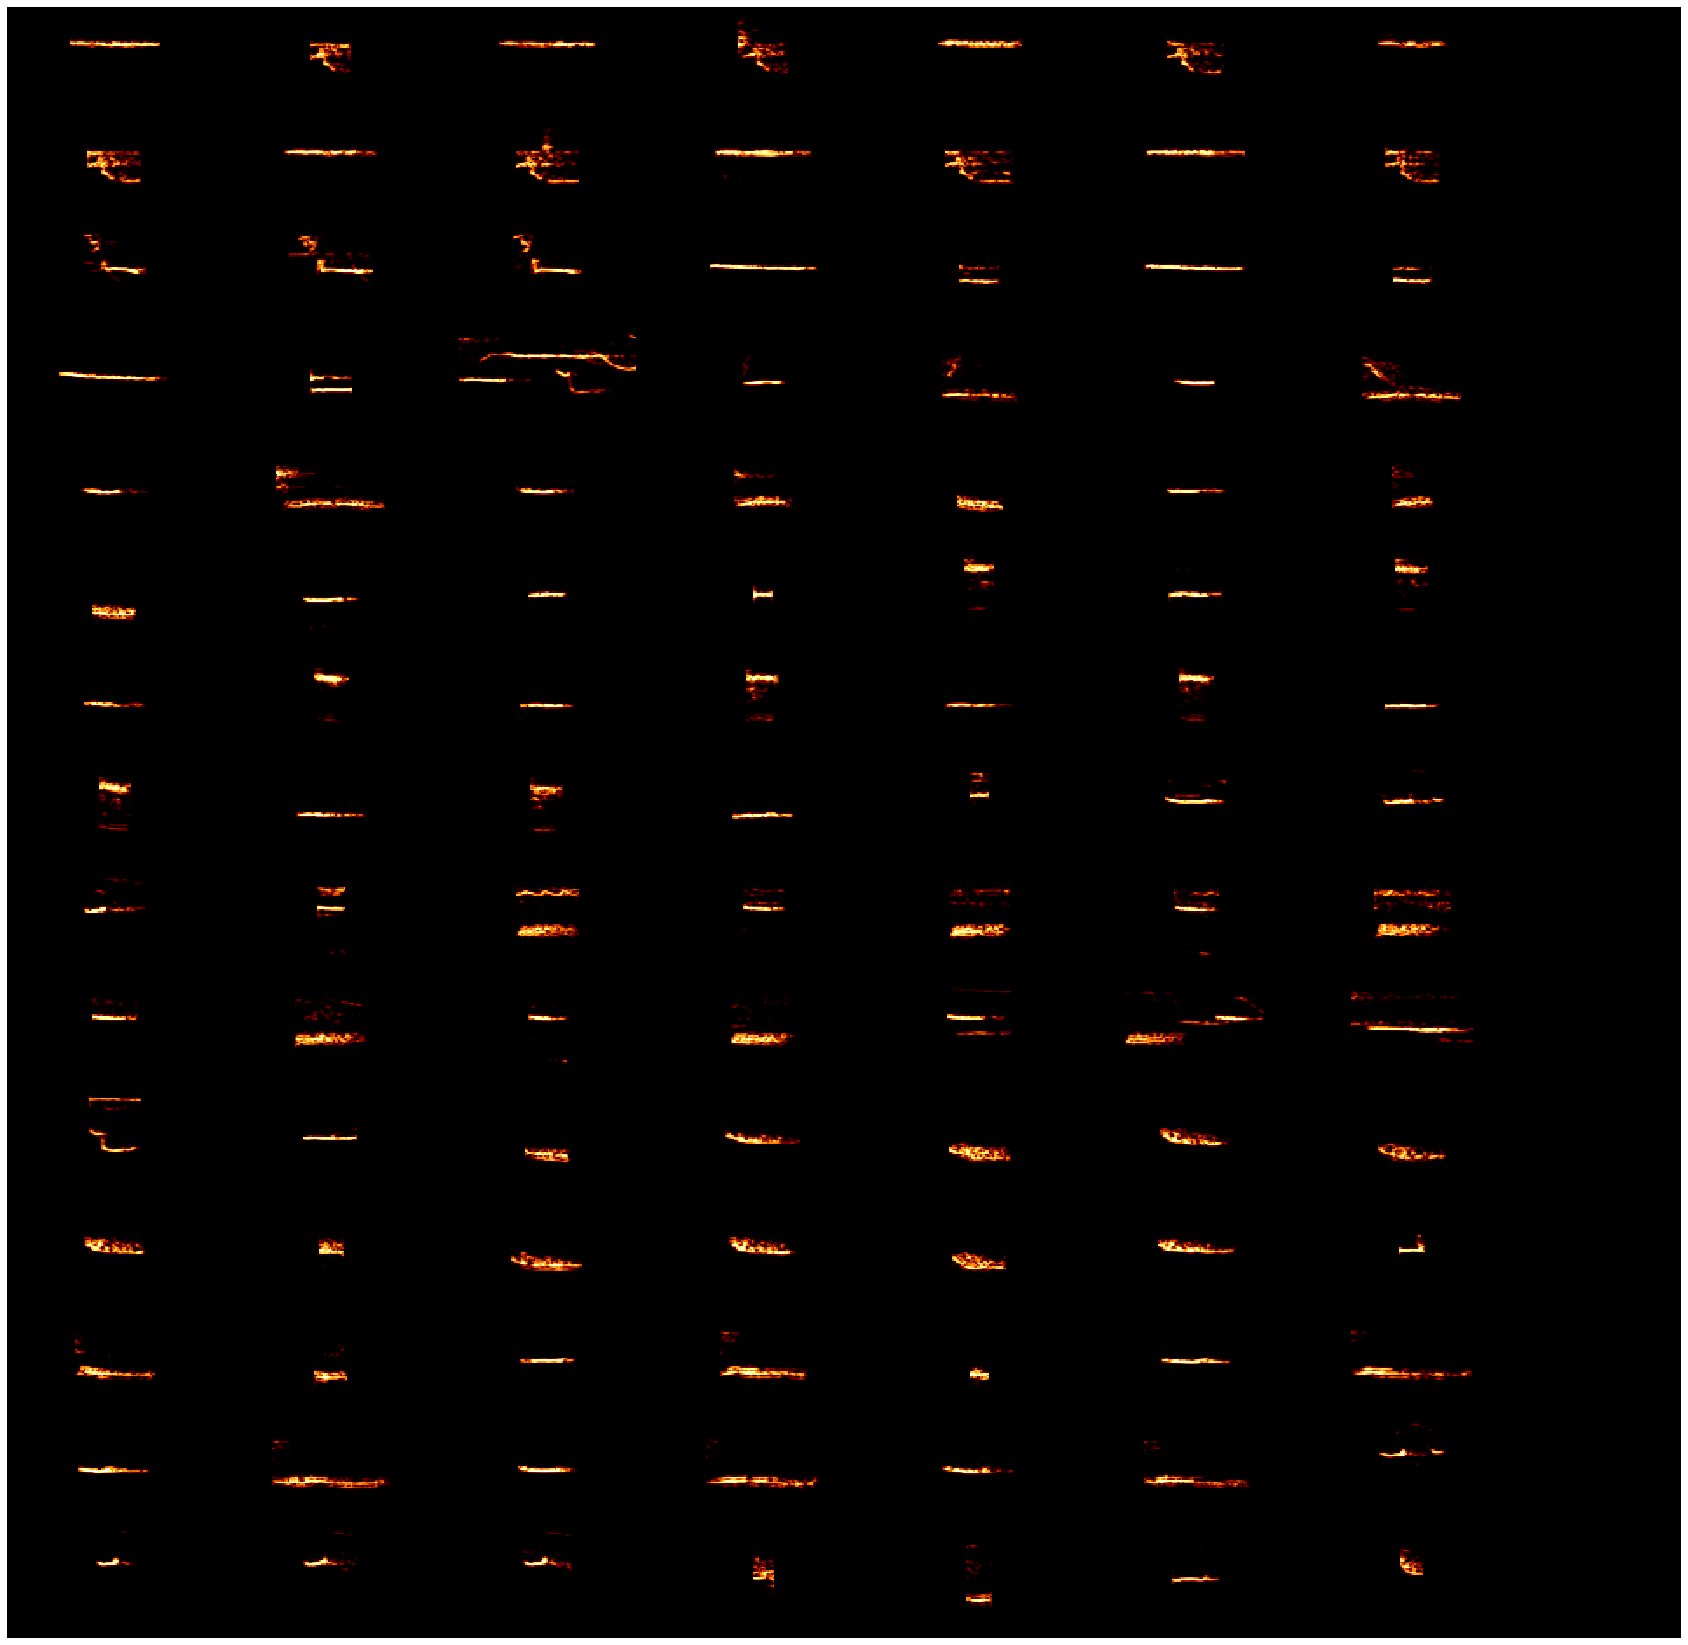

In [10]:
np.shape(syllables_spec)
draw_spec_set(syllables_spec, zoom=2, maxrows=15, colsize=15)

### Clip range and convert to uint8

In [11]:
# Clip range to add contrast
def contrast(x):
    minval = np.percentile(x, 5)
    maxval = np.percentile(x, 100)
    x = np.clip(x, minval, maxval)
    x = ((x - minval) / (maxval - minval)) * 255
    return x

syllables_spec = [contrast(i).astype("uint8") for i in tqdm(syllables_spec)]
syllable_df["spectrogram"] = syllables_spec


100%|██████████| 6523/6523 [00:01<00:00, 3291.86it/s]


### Plot a few sylables per individual

MP58 2565
49it [00:00, 30891.46it/s]


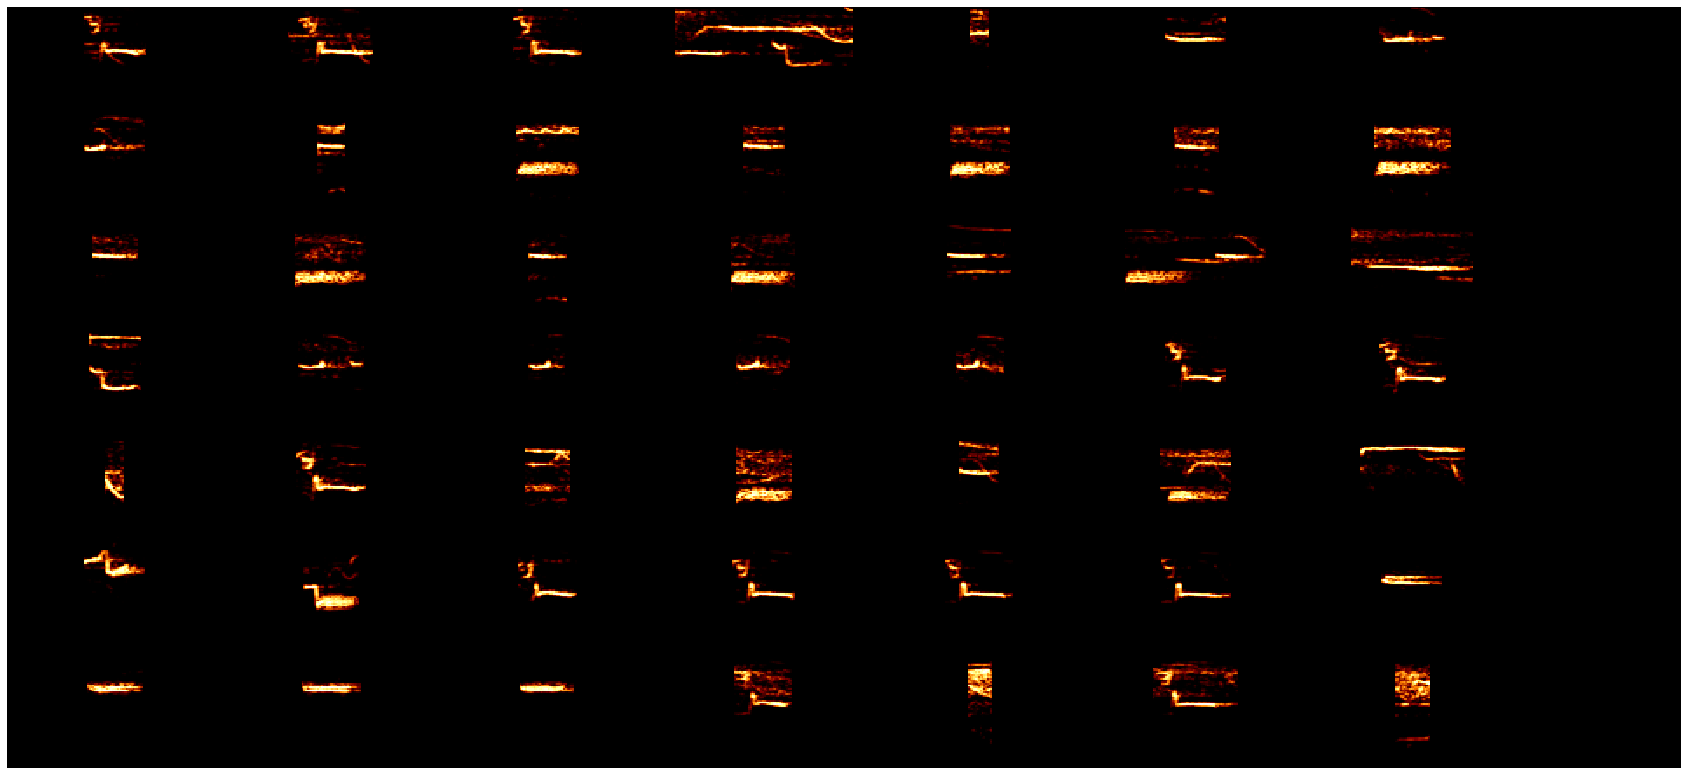

W71 3958
49it [00:00, 38429.49it/s]


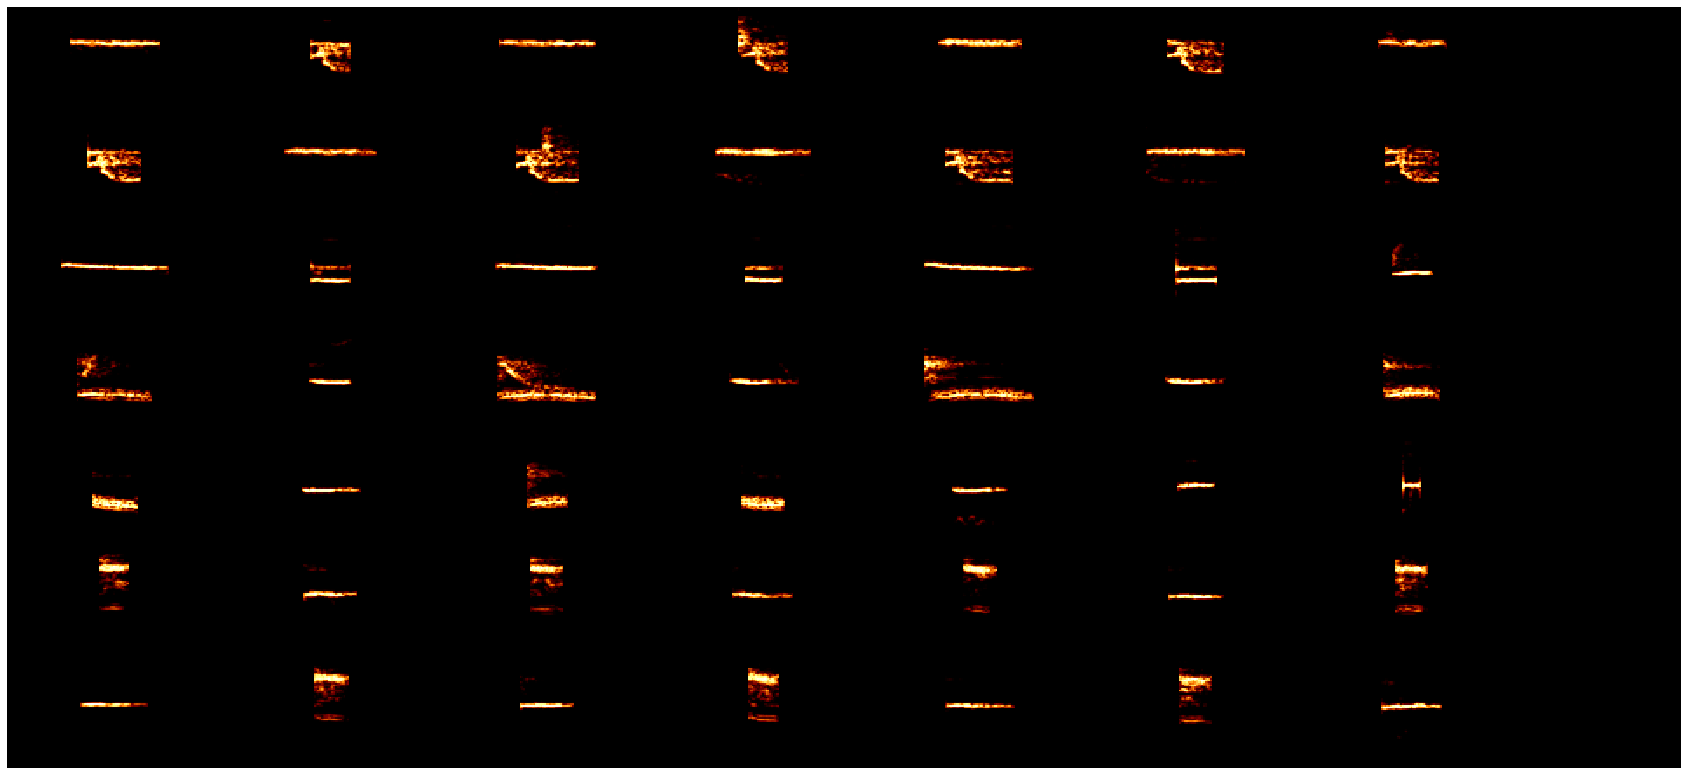

In [14]:
syllable_df.indv.unique()

for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array(
        [
            i / np.max(i)
            for i in syllable_df[syllable_df.indv == indv].spectrogram.values
        ]
    )
    specs[specs < 0] = 0
    draw_spec_set(specs, zoom=2, maxrows=7, colsize=15)

### Save entire dataset

In [12]:

save_loc = DATA_DIR / "syllable_dfs" / DATASET_ID / "{}.pickle".format(DATASET_ID)
ensure_dir(save_loc)
syllable_df.drop("audio", 1).to_pickle(save_loc)
